In [34]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline  
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
import pandas as pd
import os

In [2]:
spark = SparkSession \
    .builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/03 01:38:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/03 01:38:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Read in data
flights_2018 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2018.parquet')
flights_2019 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2019.parquet')
flights_2020 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2020.parquet')
flights_2021 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2021.parquet')
flights_2022 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2022.parquet')

In [10]:
"""
Transform data so that each row is an airline and each column is a day. 
The value of each cell is the proportion of flights for that airline on that day 
that had an arrival delay >= 15 minutes.
""" 
remove = ['Cape Air', 'Commutair Aka Champlain Enterprises, Inc.', 'Peninsula Airways Inc.']
# Combine all years, select relevant columns, drop missing
combined = flights_2018.union(flights_2019).union(flights_2020).union(flights_2021).union(flights_2022) \
    .select('FlightDate', 'Airline', 'ArrDel15').dropna()

filtered = combined.filter(~combined['Airline'].isin(remove))
# Group by airline and date, calculate proportion of delayed flights
delay_prop = filtered.groupBy('Airline', 'FlightDate') \
                .agg(F.mean('ArrDel15').alias('delay_proportion'))

# Pivot so each airline is a row and each date is a column
pivoted = delay_prop.groupBy('Airline') \
            .pivot('FlightDate') \
            .agg(F.first('delay_proportion')) \
            .orderBy('Airline')

# Fill NA values with 0
data = pivoted.fillna(0)

print(f'Shape of transformed data: {data.count()} rows, {len(data.columns)} columns.')

[Stage 27:======================================================> (29 + 1) / 30]

Shape of transformed data: 25 rows, 1674 columns.


In [11]:
# Create feature vector
feats = data.columns[1:]
assembler = VectorAssembler(inputCols=feats, outputCol='features')
dataset = assembler.transform(data)

# Show 5 rows
dataset.select('features').show(5)

25/12/03 01:44:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Stage 35:>                                                         (0 + 1) / 1]

25/12/03 01:44:57 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:44:58 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 41:>                                                         (0 + 1) / 1]

25/12/03 01:45:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 45:>                                                         (0 + 1) / 1]

+--------------------+
|            features|
+--------------------+
|[0.52662721893491...|
|[0.16359918200409...|
|[0.34600760456273...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
+--------------------+
only showing top 5 rows



In [35]:
# Create function to find optimal k
def kmeans_range(lower, upper, data):
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop thru k's
    for k in range(lower, upper+1, 1):
        # Instatiate with current k
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit
        model = kmeans.fit(data)
        
        # Predict
        preds = model.transform(data)
        
        # Calculate sil score
        sil = evaluator.evaluate(preds)

        # Append to output df
        output = pd.concat([output, pd.DataFrame(data={'k': [k], 'silhouette': [sil]})])
    
    return output.reset_index().drop(columns=['index'])

# Create function to find optimal k
def bkm_range(lower, upper, data):
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop thru k's
    for k in range(lower, upper+1, 1):
        # Instatiate with current k
        bkm = BisectingKMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit
        model = bkm.fit(data)
        
        # Predict
        preds = model.transform(data)
        
        # Calculate sil score
        sil = evaluator.evaluate(preds)

        # Append to output df
        output = pd.concat([output, pd.DataFrame(data={'k': [k], 'silhouette': [sil]})])
    
    return output.reset_index().drop(columns=['index'])

In [36]:
# Loop through various k values and view results
comparison_bkm = bkm_range(2, 10, dataset)

[Stage 1114:====================================================> (29 + 1) / 30]

25/12/03 02:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:12:29 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 1122:>                                                       (0 + 1) / 1]

25/12/03 02:12:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:12:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:12:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:12:33 WARN DAGScheduler: Broadcasting larg

[Stage 1232:====================================================> (29 + 1) / 30]

25/12/03 02:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 1240:>                                                       (0 + 1) / 1]

25/12/03 02:12:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1244:>                                                       (0 + 1) / 1]

25/12/03 02:12:41 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 1250:====================================================> (29 + 1) / 30]

25/12/03 02:12:45 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 1258:>                                                       (0 + 1) / 1]

25/12/03 02:12:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1264:====================================================> (29 + 1) / 30]

25/12/03 02:12:51 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 1272:>                                                       (0 + 1) / 1]

25/12/03 02:12:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1282:====================================================> (29 + 1) / 30]

25/12/03 02:12:57 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 1290:>                                                       (0 + 1) / 1]

25/12/03 02:12:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:13:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:13:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:02 WARN DAGScheduler: Broadcasting larg

[Stage 1500:====================================================> (29 + 1) / 30]

25/12/03 02:13:10 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 1508:>                                                       (0 + 1) / 1]

25/12/03 02:13:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1512:>                                                       (0 + 1) / 1]

25/12/03 02:13:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 1520:>                                                       (0 + 1) / 1]

25/12/03 02:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:13:18 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 1526:>                                                       (0 + 1) / 1]

25/12/03 02:13:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1532:====================================================> (29 + 1) / 30]

25/12/03 02:13:23 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 1540:>                                                       (0 + 1) / 1]

25/12/03 02:13:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1550:====================================================> (29 + 1) / 30]

25/12/03 02:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 1558:>                                                       (0 + 1) / 1]

25/12/03 02:13:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:13:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:13:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:13:34 WARN DAGScheduler: Broadcasting larg

[Stage 1768:====================================================> (29 + 1) / 30]

25/12/03 02:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 1776:>                                                       (0 + 1) / 1]

25/12/03 02:13:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1780:>                                                       (0 + 1) / 1]

25/12/03 02:13:44 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 1786:====================================================> (29 + 1) / 30]

25/12/03 02:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:13:49 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 1794:>                                                       (0 + 1) / 1]

25/12/03 02:13:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1800:====================================================> (29 + 1) / 30]

25/12/03 02:13:54 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 1808:>                                                       (0 + 1) / 1]

25/12/03 02:13:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1818:====================================================> (29 + 1) / 30]

25/12/03 02:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:14:01 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 1826:>                                                       (0 + 1) / 1]

25/12/03 02:14:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:14:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:14:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:05 WARN DAGScheduler: Broadcasting larg

[Stage 2136:====================================================> (29 + 1) / 30]

25/12/03 02:14:15 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:14:16 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 2144:>                                                       (0 + 1) / 1]

25/12/03 02:14:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/03 02:14:18 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 2154:====================================================> (29 + 1) / 30]

25/12/03 02:14:22 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:14:22 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 2162:>                                                       (0 + 1) / 1]

25/12/03 02:14:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2168:====================================================> (29 + 1) / 30]

25/12/03 02:14:28 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 2176:>                                                       (0 + 1) / 1]

25/12/03 02:14:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2186:====================================================> (29 + 1) / 30]

25/12/03 02:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 2194:>                                                       (0 + 1) / 1]

25/12/03 02:14:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:14:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:14:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:14:39 WARN DAGScheduler: Broadcasting larg

[Stage 2504:====================================================> (29 + 1) / 30]

25/12/03 02:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 2512:>                                                       (0 + 1) / 1]

25/12/03 02:14:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/03 02:14:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 2522:====================================================> (29 + 1) / 30]

25/12/03 02:14:55 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 2530:>                                                       (0 + 1) / 1]

25/12/03 02:14:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2536:====================================================> (29 + 1) / 30]

25/12/03 02:15:01 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:15:02 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 2544:>                                                       (0 + 1) / 1]

25/12/03 02:15:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2554:====================================================> (29 + 1) / 30]

25/12/03 02:15:07 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 2562:>                                                       (0 + 1) / 1]

25/12/03 02:15:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:15:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:12 WARN DAGScheduler: Broadcasting larg

[Stage 2872:====================================================> (29 + 1) / 30]

25/12/03 02:15:22 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 2880:>                                                       (0 + 1) / 1]

25/12/03 02:15:24 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2884:>                                                       (0 + 1) / 1]

25/12/03 02:15:25 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 2890:====================================================> (29 + 1) / 30]

25/12/03 02:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 2898:>                                                       (0 + 1) / 1]

25/12/03 02:15:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2904:====================================================> (29 + 1) / 30]

25/12/03 02:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 2912:>                                                       (0 + 1) / 1]

25/12/03 02:15:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2922:====================================================> (29 + 1) / 30]

25/12/03 02:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 2930:>                                                       (0 + 1) / 1]

25/12/03 02:15:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:15:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:15:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:15:46 WARN DAGScheduler: Broadcasting larg

[Stage 3240:====================================================> (29 + 1) / 30]

25/12/03 02:15:56 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:15:57 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 3248:>                                                       (0 + 1) / 1]

25/12/03 02:15:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3252:>                                                       (0 + 1) / 1]

25/12/03 02:15:58 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 3258:====================================================> (29 + 1) / 30]

25/12/03 02:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 3266:>                                                       (0 + 1) / 1]

25/12/03 02:16:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3272:====================================================> (29 + 1) / 30]

25/12/03 02:16:09 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:16:09 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 3280:>                                                       (0 + 1) / 1]

25/12/03 02:16:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3290:====================================================> (29 + 1) / 30]

25/12/03 02:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 3298:>                                                       (0 + 1) / 1]

25/12/03 02:16:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:16:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:16:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:19 WARN DAGScheduler: Broadcasting larg

[Stage 3708:====================================================> (29 + 1) / 30]

25/12/03 02:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:16:33 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 3716:>                                                       (0 + 1) / 1]

25/12/03 02:16:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/12/03 02:16:35 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 3726:====================================================> (29 + 1) / 30]

25/12/03 02:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 3734:>                                                       (0 + 1) / 1]

25/12/03 02:16:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3740:====================================================> (29 + 1) / 30]

25/12/03 02:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 3748:>                                                       (0 + 1) / 1]

25/12/03 02:16:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3758:====================================================> (29 + 1) / 30]

25/12/03 02:16:51 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:16:51 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 3766:>                                                       (0 + 1) / 1]

25/12/03 02:16:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:16:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:16:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:16:55 WARN DAGScheduler: Broadcasting larg

[Stage 4176:====================================================> (29 + 1) / 30]

25/12/03 02:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 4184:>                                                       (0 + 1) / 1]

25/12/03 02:17:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 4188:>                                                       (0 + 1) / 1]

25/12/03 02:17:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 4194:====================================================> (29 + 1) / 30]

25/12/03 02:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 4202:>                                                       (0 + 1) / 1]

25/12/03 02:17:16 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 4208:====================================================> (29 + 1) / 30]

25/12/03 02:17:21 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:17:21 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 4216:>                                                       (0 + 1) / 1]

25/12/03 02:17:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [37]:
comparison_bkm

,k,silhouette
0,2,0.290513
1,3,0.110592
2,4,0.081847
3,5,0.028328
4,6,0.016813
5,7,-0.016375
6,8,-0.009019
7,9,-0.082049
8,10,-0.082811


In [13]:
# Loop through various k values and view results
comparison = kmeans_range(2, 10, dataset)

[Stage 46:======================================================> (29 + 1) / 30]

25/12/03 01:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:45:28 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 55:======================================================> (29 + 1) / 30]

25/12/03 01:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 63:>                                                         (0 + 1) / 1]

25/12/03 01:45:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:45:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:45:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:45:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:45:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:45:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:45:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:45:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:45:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 103:=====================================================> (29 + 1) / 30]

25/12/03 01:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:45:43 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 111:>                                                        (0 + 1) / 1]

25/12/03 01:45:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 115:>                                                        (0 + 1) / 1]

25/12/03 01:45:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 121:=====================================================> (29 + 1) / 30]

25/12/03 01:45:49 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:45:50 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 129:>                                                        (0 + 1) / 1]

25/12/03 01:45:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 135:=====================================================> (29 + 1) / 30]

25/12/03 01:45:56 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:45:57 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 143:>                                                        (0 + 1) / 1]

25/12/03 01:45:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 153:=====================================================> (29 + 1) / 30]

25/12/03 01:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 161:>                                                        (0 + 1) / 1]

25/12/03 01:46:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:46:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 206:=====================================================> (29 + 1) / 30]

25/12/03 01:46:11 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:46:12 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 214:>                                                        (0 + 1) / 1]

25/12/03 01:46:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 218:>                                                        (0 + 1) / 1]

25/12/03 01:46:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 224:=====================================================> (29 + 1) / 30]

25/12/03 01:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 232:>                                                        (0 + 1) / 1]

25/12/03 01:46:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 238:=====================================================> (29 + 1) / 30]

25/12/03 01:46:24 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:46:25 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 246:>                                                        (0 + 1) / 1]

25/12/03 01:46:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 256:=====================================================> (29 + 1) / 30]

25/12/03 01:46:30 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 264:>                                                        (0 + 1) / 1]

25/12/03 01:46:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:46:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:46:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 309:=====================================================> (29 + 1) / 30]

25/12/03 01:46:39 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:46:40 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 317:>                                                        (0 + 1) / 1]

25/12/03 01:46:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 321:>                                                        (0 + 1) / 1]

25/12/03 01:46:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 327:=====================================================> (29 + 1) / 30]

25/12/03 01:46:46 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 335:>                                                        (0 + 1) / 1]

25/12/03 01:46:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 341:=====================================================> (29 + 1) / 30]

25/12/03 01:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:46:53 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 349:>                                                        (0 + 1) / 1]

25/12/03 01:46:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 361:>                                                        (0 + 1) / 1]

25/12/03 01:46:58 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:46:59 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 367:>                                                        (0 + 1) / 1]

25/12/03 01:47:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:47:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 407:=====================================================> (29 + 1) / 30]

25/12/03 01:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:47:08 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 415:>                                                        (0 + 1) / 1]

25/12/03 01:47:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 419:>                                                        (0 + 1) / 1]

25/12/03 01:47:09 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 425:=====================================================> (29 + 1) / 30]

25/12/03 01:47:14 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:47:14 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 433:>                                                        (0 + 1) / 1]

25/12/03 01:47:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 439:=====================================================> (29 + 1) / 30]

25/12/03 01:47:20 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 447:>                                                        (0 + 1) / 1]

25/12/03 01:47:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 457:=====================================================> (29 + 1) / 30]

25/12/03 01:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 465:>                                                        (0 + 1) / 1]

25/12/03 01:47:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:47:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 505:=====================================================> (29 + 1) / 30]

25/12/03 01:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 513:>                                                        (0 + 1) / 1]

25/12/03 01:47:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 517:>                                                        (0 + 1) / 1]

25/12/03 01:47:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 523:=====================================================> (29 + 1) / 30]

25/12/03 01:47:41 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:47:42 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 531:>                                                        (0 + 1) / 1]

25/12/03 01:47:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 537:=====================================================> (29 + 1) / 30]

25/12/03 01:47:48 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:47:49 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 545:>                                                        (0 + 1) / 1]

25/12/03 01:47:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 555:=====================================================> (29 + 1) / 30]

25/12/03 01:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:47:55 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 563:>                                                        (0 + 1) / 1]

25/12/03 01:47:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:47:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:47:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 605:>                                                        (0 + 1) / 1]

25/12/03 01:48:02 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 611:>                                                        (0 + 1) / 1]

25/12/03 01:48:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 615:>                                                        (0 + 1) / 1]

25/12/03 01:48:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 621:=====================================================> (29 + 1) / 30]

25/12/03 01:48:09 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 629:>                                                        (0 + 1) / 1]

25/12/03 01:48:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 635:=====================================================> (29 + 1) / 30]

25/12/03 01:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 643:>                                                        (0 + 1) / 1]

25/12/03 01:48:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 653:=====================================================> (29 + 1) / 30]

25/12/03 01:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 661:>                                                        (0 + 1) / 1]

25/12/03 01:48:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 701:=====================================================> (29 + 1) / 30]

25/12/03 01:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 709:>                                                        (0 + 1) / 1]

25/12/03 01:48:32 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/03 01:48:33 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 719:=====================================================> (29 + 1) / 30]

25/12/03 01:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 727:>                                                        (0 + 1) / 1]

25/12/03 01:48:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 733:=====================================================> (29 + 1) / 30]

25/12/03 01:48:43 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 741:>                                                        (0 + 1) / 1]

25/12/03 01:48:45 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 751:=======================================================(30 + 0) / 30]

25/12/03 01:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:48:50 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 759:>                                                        (0 + 1) / 1]

25/12/03 01:48:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:48:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:48:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 794:=====================================================> (29 + 1) / 30]

25/12/03 01:48:57 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 802:>                                                        (0 + 1) / 1]

25/12/03 01:48:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 806:>                                                        (0 + 1) / 1]

25/12/03 01:49:00 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 812:=====================================================> (29 + 1) / 30]

25/12/03 01:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:49:05 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 820:>                                                        (0 + 1) / 1]

25/12/03 01:49:05 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 826:=====================================================> (29 + 1) / 30]

25/12/03 01:49:10 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 834:>                                                        (0 + 1) / 1]

25/12/03 01:49:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 844:=====================================================> (29 + 1) / 30]

25/12/03 01:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 852:>                                                        (0 + 1) / 1]

25/12/03 01:49:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:49:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:49:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:49:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:49:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:49:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:49:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:49:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 887:=====================================================> (29 + 1) / 30]

25/12/03 01:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 895:>                                                        (0 + 1) / 1]

25/12/03 01:49:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/03 01:49:27 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 905:=====================================================> (29 + 1) / 30]

25/12/03 01:49:31 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:49:32 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 913:>                                                        (0 + 1) / 1]

25/12/03 01:49:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 919:=====================================================> (29 + 1) / 30]

25/12/03 01:49:38 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:49:38 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 927:>                                                        (0 + 1) / 1]

25/12/03 01:49:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


In [14]:
comparison

,k,silhouette
0,2,0.209894
1,3,0.195417
2,4,0.214073
3,5,0.168027
4,6,0.196905
5,7,0.194469
6,8,0.028804
7,9,0.093267
8,10,0.097217


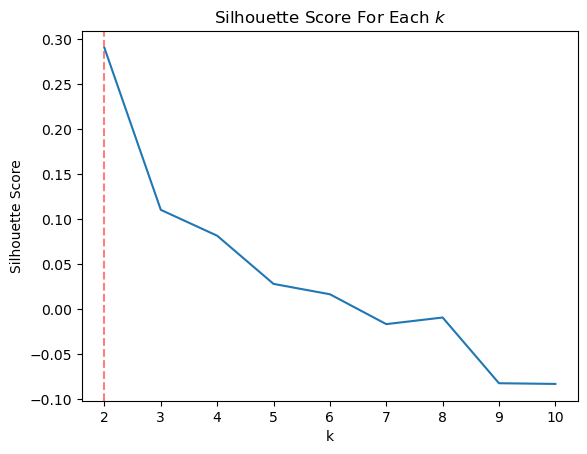

In [38]:
# Visualize
import matplotlib.pyplot as plt
x=comparison_bkm.k
y=comparison_bkm.silhouette
optimal_k = comparison_bkm.loc[comparison_bkm['silhouette'].idxmax(), 'k']
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal k={int(optimal_k)}')
plt.plot(x, y)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Each $k$')
plt.savefig('airling_bkm_silhouette_scores.png')
plt.show()

In [17]:
# Refit with k=2
kmeans = KMeans().setK(4).setSeed(314).setMaxIter(20)
# Fit
model = kmeans.fit(dataset)
        
# Predict
preds = model.transform(dataset)

[Stage 937:=====================================================> (29 + 1) / 30]

25/12/03 01:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 01:51:11 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 945:>                                                        (0 + 1) / 1]

25/12/03 01:51:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 01:51:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:51:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:51:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:51:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:51:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:51:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:51:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:51:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 01:51:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 990:=====================================================> (29 + 1) / 30]

25/12/03 01:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 998:>                                                        (0 + 1) / 1]

25/12/03 01:51:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1002:>                                                       (0 + 1) / 1]

25/12/03 01:51:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [19]:
preds.select('Airline', 'prediction').orderBy('prediction').show(30, truncate=False)

[Stage 1021:====================================================> (29 + 1) / 30]

25/12/03 01:52:47 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 1029:>                                                       (0 + 1) / 1]

25/12/03 01:52:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
+----------------------------------------+----------+
|Airline                                 |prediction|
+----------------------------------------+----------+
|Trans States Airlines                   |0         |
|Compass Airlines                        |0         |
|Empire Airlines Inc.                    |0         |
|ExpressJet Airlines Inc.                |0         |
|Allegiant Air                           |1         |
|Frontier Airlines Inc.                  |1         |
|GoJet Airlines, LLC d/b/a United Express|1         |
|Southwest Airlines Co.                  |1         |
|JetBlue Airways                         |1         |
|Spirit Air Lines                        |1         |
|Delta Air Lines Inc.                    |2         |
|Air Wisconsin Airlines Corp             |2         |
|Endeavor Air Inc.                       |2         |
|Horizon Air                             |2       

#### So with $k=4$, which has the highest silhouette score, we can see how each airline is clustered. Virginia America is the only airline in group 4, so could be worth exploring the clusters.

In [39]:
# Refit with k=2
bkm = BisectingKMeans().setK(2).setSeed(314).setMaxIter(20)
# Fit
model_bkm = bkm.fit(dataset)
        
# Predict
preds_bkm = model_bkm.transform(dataset)

preds_bkm.select('Airline', 'prediction').orderBy('prediction').show(30, truncate=False)

[Stage 4226:====================================================> (29 + 1) / 30]

25/12/03 02:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 4234:>                                                       (0 + 1) / 1]

25/12/03 02:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting larg

[Stage 4344:====================================================> (29 + 1) / 30]

25/12/03 02:22:31 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 4352:>                                                       (0 + 1) / 1]

25/12/03 02:22:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 4356:>                                                       (0 + 1) / 1]

25/12/03 02:22:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 4362:====================================================> (29 + 1) / 30]

25/12/03 02:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 4370:>                                                       (0 + 1) / 1]

25/12/03 02:22:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
+----------------------------------------+----------+
|Airline                                 |prediction|
+----------------------------------------+----------+
|Capital Cargo International             |0         |
|Delta Air Lines Inc.                    |0         |
|Hawaiian Airlines Inc.                  |0         |
|Horizon Air                             |0         |
|Empire Airlines Inc.                    |0         |
|Trans States Airlines                   |0         |
|Virgin America                          |0         |
|Compass Airlines                        |0         |
|Endeavor Air Inc.                       |0         |
|ExpressJet Airlines Inc.                |0         |
|Air Wisconsin Airlines Corp             |1         |
|Envoy Air                               |1         |
|Alaska Airlines Inc.                    |1         |
|Frontier Airlines Inc.                  |1       